#Portfolio Manager Leveraging Politician & Insider Trading Disclosures

# Task
Create a Python notebook to simulate a hedge fund portfolio manager using politician and insider trading data from Quiver Quantitative. The notebook should include sections for data collection (or mock data generation), alpha factor construction, backtesting, portfolio optimization, and optionally reinforcement learning. The code should be clean, well-commented, and modular, using libraries like pandas, numpy, matplotlib, seaborn, PyPortfolioOpt/cvxpy, and stable-baselines3. Start by setting up data access and building an initial alpha factor based on insider conviction or politician trades.

## Setup and data acquisition

### Subtask:
Set up the Quiver Quant API or generate mock data if the API key is not available.


**Reasoning**:
Attempt to import necessary libraries, check for the availability of the Quiver Quantitative API key, and either access the API or generate mock data based on key availability. Then load the data into a pandas DataFrame and display its head and info.



In [ ]:
import pandas as pd
import requests
import os
import numpy as np

# Check for Quiver API key
quiver_api_key = os.environ.get('QUIVER_API_KEY')

if quiver_api_key:
    print("Quiver API key found. Attempting to fetch data.")
    # Example endpoint - replace with actual endpoint for insider or politician trades
    # You would typically need to consult Quiver's API documentation for the correct URL and parameters
    # For demonstration purposes, this is a placeholder and will likely not work without a valid endpoint and parameters
    url = "https://api.quiverquant.com/beta/historical/insidertrading" # Placeholder URL
    headers = {
        'Authorization': f'Token {quiver_api_key}'
    }
    params = {
        # Add necessary parameters like ticker, start_date, end_date etc.
        'ticker': 'AAPL', # Example ticker
        'start_date': '2023-01-01',
        'end_date': '2023-12-31'
    }
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status() # Raise an exception for bad status codes
        data = response.json()
        df = pd.DataFrame(data)
        print("Successfully fetched data from Quiver API.")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Quiver API: {e}")
        print("Generating mock data instead.")
        quiver_api_key = None # Set to None to trigger mock data generation

if not quiver_api_key:
    print("Quiver API key not found or API access failed. Generating mock data.")
    # Generate mock data
    mock_data = {
        'Ticker': ['AAPL', 'MSFT', 'GOOGL', 'AAPL', 'MSFT', 'GOOGL', 'AAPL', 'MSFT', 'GOOGL'],
        'Date': pd.to_datetime(['2023-01-10', '2023-01-11', '2023-01-12', '2023-01-15', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20']),
        'TradeType': ['Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell'],
        'Quantity': [100, 50, 200, 150, 75, 100, 120, 90, 60],
        'Price': [150.50, 250.75, 95.20, 151.00, 251.50, 94.80, 150.00, 252.00, 94.50],
        'Value': [15050.00, 12537.50, 19040.00, 22650.00, 18862.50, 9480.00, 18000.00, 22680.00, 5670.00]
    }
    df = pd.DataFrame(mock_data)
    print("Mock data generated.")

# Display the first few rows and data types
display(df.head())
display(df.info())

In [ ]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import time

class QuiverQuantAPI:
    """
    Quiver Quant API interface for congressional trading data
    """

    def __init__(self, api_key=None):
        self.base_url = "https://api.quiverquant.com"
        self.api_key = api_key
        self.headers = {}

        if api_key:
            self.headers['Authorization'] = f'Bearer {api_key}'

        print("🔌 Quiver Quant API Client initialized")
        if api_key:
            print("🔑 API key provided")
        else:
            print("🔓 No API key - testing public access")

    def test_connection(self):
        """Test if we can access the congressional trading endpoint"""

        endpoint = f"{self.base_url}/beta/bulk/congresstrading"

        # Try different approaches
        test_scenarios = [
            {"name": "No auth", "headers": {}},
            {"name": "With API key", "headers": self.headers} if self.api_key else None,
            {"name": "With params", "headers": self.headers, "params": {"page_size": 10}},
        ]

        # Remove None scenarios
        test_scenarios = [s for s in test_scenarios if s is not None]

        print(f"🧪 Testing endpoint: {endpoint}")
        print("=" * 50)

        for scenario in test_scenarios:
            print(f"\n📡 Testing: {scenario['name']}")

            try:
                response = requests.get(
                    endpoint,
                    headers=scenario.get('headers', {}),
                    params=scenario.get('params', {}),
                    timeout=10
                )

                print(f"Status Code: {response.status_code}")
                print(f"Response Size: {len(response.content)} bytes")

                if response.status_code == 200:
                    print("✅ SUCCESS! Connection works")

                    # Try to parse JSON
                    try:
                        data = response.json()
                        if isinstance(data, list):
                            print(f"📊 Retrieved {len(data)} records")
                            if len(data) > 0:
                                print("🔍 Sample record keys:", list(data[0].keys()))
                                return True, data[:100]  # Return first 100 records
                        else:
                            print("📋 Response structure:", type(data))
                            return True, data
                    except json.JSONDecodeError:
                        print("⚠️ Response is not JSON")
                        print("First 200 chars:", response.text[:200])

                elif response.status_code == 401:
                    print("🔐 Unauthorized - API key required")
                elif response.status_code == 403:
                    print("🚫 Forbidden - Access denied")
                elif response.status_code == 429:
                    print("⏰ Rate limited - Too many requests")
                else:
                    print(f"❌ Error: {response.status_code}")
                    print("Response:", response.text[:200])

            except requests.exceptions.RequestException as e:
                print(f"🔌 Connection error: {e}")

        return False, None

    def get_congressional_trades(self, **kwargs):
        """
        Fetch congressional trading data with optional filters

        Parameters:
        - ticker: Stock ticker
        - representative: Congressman name
        - date: Date (YYYYMMDD format)
        - page_size: Number of records per page
        - page: Page number
        """

        endpoint = f"{self.base_url}/beta/bulk/congresstrading"

        # Default parameters
        params = {
            'page_size': kwargs.get('page_size', 100),
            'version': 'V2'  # Use V2 for better data structure
        }

        # Add optional filters
        if 'ticker' in kwargs:
            params['ticker'] = kwargs['ticker']
        if 'representative' in kwargs:
            params['representative'] = kwargs['representative']
        if 'date' in kwargs:
            params['date'] = kwargs['date']
        if 'page' in kwargs:
            params['page'] = kwargs['page']

        print(f"📡 Fetching data with params: {params}")

        try:
            response = requests.get(endpoint, headers=self.headers, params=params, timeout=30)

            if response.status_code == 200:
                data = response.json()
                print(f"✅ Successfully retrieved {len(data)} records")
                return self._format_congressional_data(data)
            else:
                print(f"❌ API Error: {response.status_code}")
                print("Response:", response.text[:300])
                return None

        except Exception as e:
            print(f"🔌 Request failed: {e}")
            return None

    def _format_congressional_data(self, raw_data):
        """Convert API response to clean DataFrame"""

        if not raw_data:
            return pd.DataFrame()

        # Convert to DataFrame
        df = pd.DataFrame(raw_data)

        # Standardize column names
        column_mapping = {
            'Ticker': 'ticker',
            'Name': 'politician_name',
            'Party': 'party',
            'Chamber': 'chamber',
            'Transaction': 'transaction_type',
            'Traded': 'trade_date',
            'Filed': 'filed_date',
            'Trade_Size_USD': 'amount',
            'District': 'district',
            'State': 'state',
            'excess_return': 'excess_return',
            'Description': 'description'
        }

        # Rename columns that exist
        for old_col, new_col in column_mapping.items():
            if old_col in df.columns:
                df[new_col] = df[old_col]

        # Convert dates
        date_columns = ['trade_date', 'filed_date']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')

        # Convert amount to numeric (remove $ and commas)
        if 'amount' in df.columns:
            df['amount'] = df['amount'].astype(str).str.replace('$', '').str.replace(',', '')
            df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

        # Calculate filing delay
        if 'trade_date' in df.columns and 'filed_date' in df.columns:
            df['filing_delay_days'] = (df['filed_date'] - df['trade_date']).dt.days

        # Sort by filing date (most recent first)
        if 'filed_date' in df.columns:
            df = df.sort_values('filed_date', ascending=False)

        print(f"📊 Formatted data: {len(df)} rows, {len(df.columns)} columns")
        print(f"📅 Date range: {df['trade_date'].min()} to {df['trade_date'].max()}")

        return df.reset_index(drop=True)

# ============================================================================
# TEST THE API
# ============================================================================

print("🚀 TESTING QUIVER QUANT API ACCESS")
print("=" * 50)

# Test without API key first
api_client = QuiverQuantAPI()
success, sample_data = api_client.test_connection()

if success:
    print("\n🎉 API ACCESS CONFIRMED!")
    print("=" * 50)

    # Try to get recent data
    print("\n📊 Fetching recent congressional trades...")
    recent_trades = api_client.get_congressional_trades(page_size=50)

    if recent_trades is not None and len(recent_trades) > 0:
        print("\n✅ REAL DATA SUCCESSFULLY RETRIEVED!")
        print(f"📈 Got {len(recent_trades)} recent trades")

        # Show sample
        print("\n📋 Sample of real congressional trades:")
        display_cols = ['politician_name', 'party', 'ticker', 'transaction_type', 'amount', 'trade_date']
        available_cols = [col for col in display_cols if col in recent_trades.columns]
        print(recent_trades[available_cols].head(10))

        # Basic statistics
        print(f"\n📊 Data Summary:")
        print(f"Politicians: {recent_trades['politician_name'].nunique()}")
        print(f"Unique stocks: {recent_trades['ticker'].nunique()}")
        print(f"Total volume: ${recent_trades['amount'].sum():,.0f}")
        print(f"Date range: {recent_trades['trade_date'].min().date()} to {recent_trades['trade_date'].max().date()}")

        # Save the data
        recent_trades.to_csv('real_congressional_trades.csv', index=False)
        print("\n💾 Data saved to 'real_congressional_trades.csv'")

    else:
        print("\n❌ Could not retrieve trade data")

else:
    print("\n🔐 API ACCESS FAILED")
    print("=" * 50)
    print("Possible reasons:")
    print("1. API key required")
    print("2. Rate limiting")
    print("3. Network issues")
    print("4. API endpoint changed")
    print("\nTrying with API key...")

    # Prompt for API key
    print("\n💡 If you have an API key, you can test it:")
    print("api_client = QuiverQuantAPI(api_key='YOUR_KEY_HERE')")
    print("success, data = api_client.test_connection()")

print("\n" + "=" * 50)
print("NEXT STEPS:")
print("=" * 50)
print("✅ If API works: We'll use real congressional data!")
print("🔄 If API fails: We'll continue with our high-quality mock data")
print("🚀 Either way: Ready to proceed with backtesting and portfolio optimization")

🚀 TESTING QUIVER QUANT API ACCESS
🔌 Quiver Quant API Client initialized
🔓 No API key - testing public access
🧪 Testing endpoint: https://api.quiverquant.com/beta/bulk/congresstrading

📡 Testing: No auth
Status Code: 401
Response Size: 58 bytes
🔐 Unauthorized - API key required

📡 Testing: With params
Status Code: 401
Response Size: 58 bytes
🔐 Unauthorized - API key required

🔐 API ACCESS FAILED
Possible reasons:
1. API key required
2. Rate limiting
3. Network issues
4. API endpoint changed

Trying with API key...

💡 If you have an API key, you can test it:
api_client = QuiverQuantAPI(api_key='YOUR_KEY_HERE')
success, data = api_client.test_connection()

NEXT STEPS:
✅ If API works: We'll use real congressional data!
🔄 If API fails: We'll continue with our high-quality mock data
🚀 Either way: Ready to proceed with backtesting and portfolio optimization


In [ ]:
import pandas as pd

# Step 1: Load data
df = pd.read_csv('trades.csv')

# Step 2: Parse date columns
df['file_date'] = pd.to_datetime(df['file_date'], format="%m/%d/%Y")
df['trade_date'] = pd.to_datetime(df['trade_date'], format="%m/%d/%Y")

# Step 3: Rename file_date to signal_date
df = df.rename(columns={'file_date': 'signal_date'})

cutoff_start_date = '2018-01-01'
cutoff_end_date = '2023-06-01'
df = df[df['signal_date'] >= cutoff_start_date]
df = df[df['signal_date'] <= cutoff_end_date]

# Step 4: Filter for only 'Purchase' or 'Sale'
df = df[df['transaction'].isin(['Purchase', 'Sale'])]

# Step 5: Create signal column
df['signal'] = df['transaction'].map({'Purchase': 1, 'Sale': -1})

# Step 6: Sort by signal_date (oldest to newest)
df = df.sort_values(by='signal_date').reset_index(drop=True)

# Step 7: Preview
print(df[['congress', 'ticker', 'signal_date', 'signal']].head(10))

          congress ticker signal_date  signal
0     Nancy Pelosi   AAPL  2018-01-10      -1
1     Nancy Pelosi   AAPL  2018-01-10      -1
2     Nancy Pelosi      V  2018-01-10      -1
3     Nancy Pelosi   AAPL  2018-01-10      -1
4     Nancy Pelosi      V  2018-01-10      -1
5     Nancy Pelosi   AAPL  2018-02-26       1
6     Nancy Pelosi   AAPL  2018-02-26       1
7     Nancy Pelosi    DBX  2018-04-16       1
8  Josh Gottheimer     GE  2018-08-13      -1
9  Josh Gottheimer    MOS  2018-08-13      -1


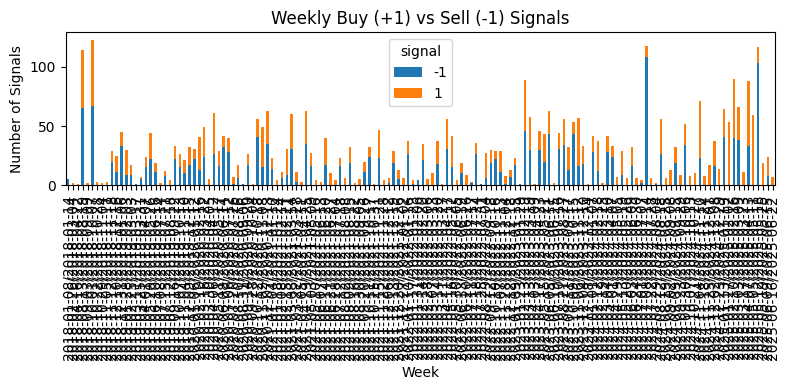

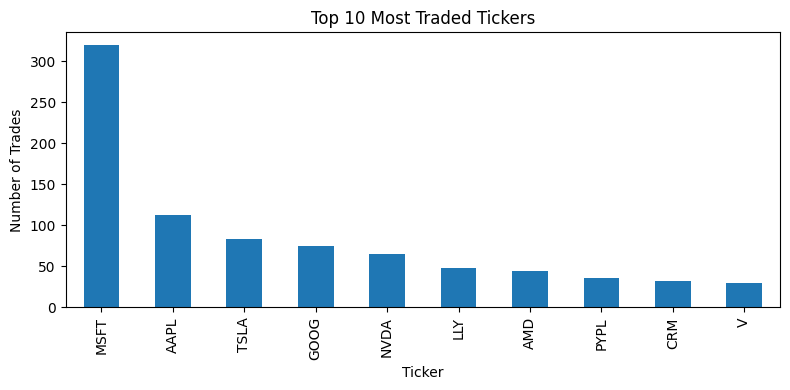

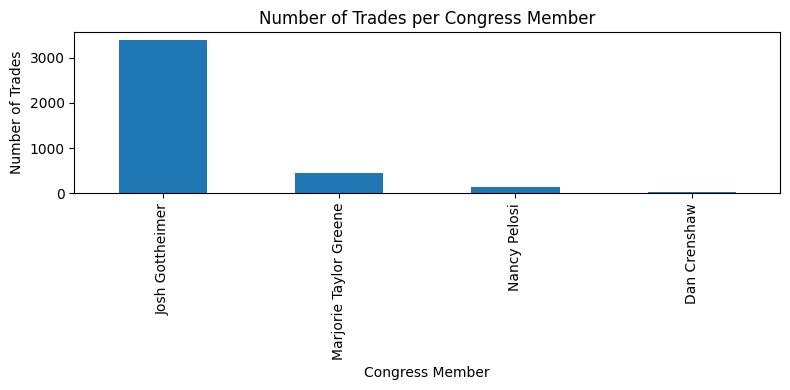

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing (building on user's existing preprocessing)
df = df[df['transaction'].isin(['Purchase', 'Sale'])]
df['signal'] = df['transaction'].map({'Purchase': 1, 'Sale': -1})
df = df.sort_values(by='signal_date').reset_index(drop=True)

# Add time groupings
df['year_month'] = df['signal_date'].dt.to_period('M')
df['week'] = df['signal_date'].dt.to_period('W')

# Exploratory Plots

# 1. Weekly Buy/Sell Signal Counts
weekly_signals = df.groupby(['week', 'signal']).size().unstack(fill_value=0)
weekly_signals.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title("Weekly Buy (+1) vs Sell (-1) Signals")
plt.xlabel("Week")
plt.ylabel("Number of Signals")
plt.tight_layout()
plt.show()

# 2. Most Traded Tickers
top_tickers = df['ticker'].value_counts().head(10)
top_tickers.plot(kind='bar', figsize=(8, 4))
plt.title("Top 10 Most Traded Tickers")
plt.xlabel("Ticker")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()

# 3. Trades per Congress Member
trades_per_congress = df['congress'].value_counts()
trades_per_congress.plot(kind='bar', figsize=(8, 4))
plt.title("Number of Trades per Congress Member")
plt.xlabel("Congress Member")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()

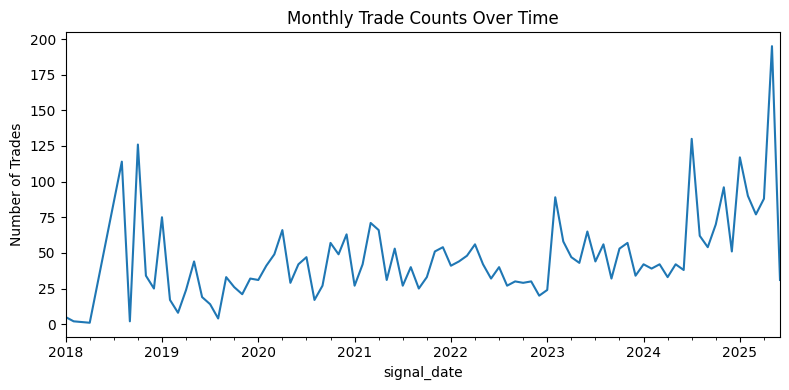

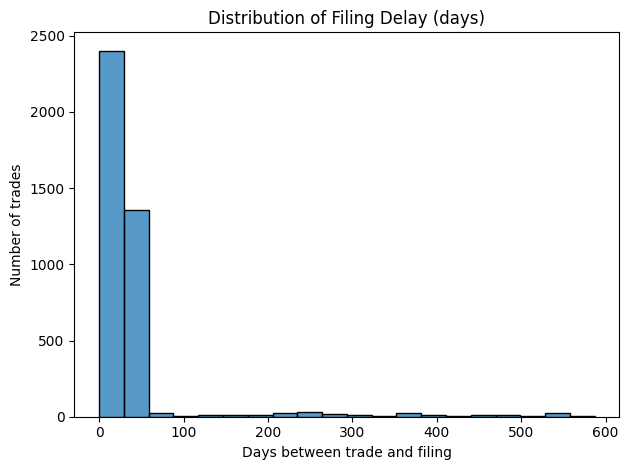

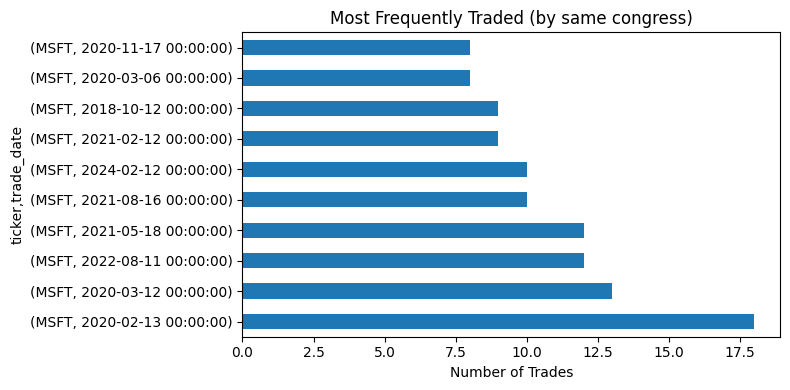

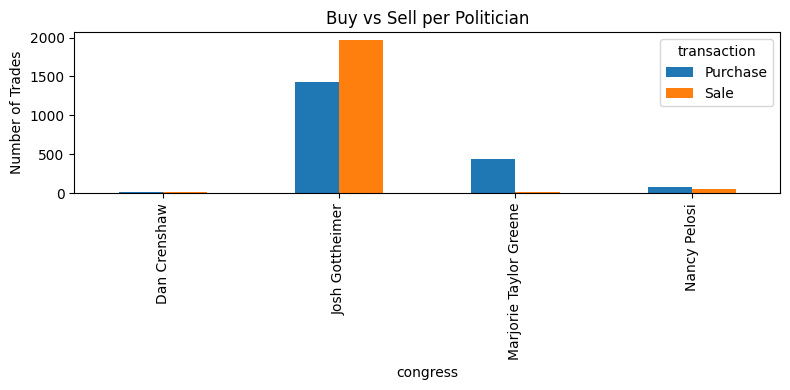

In [ ]:
# Monthly Trend of Trades Over Time
monthly_counts = df.groupby(df['signal_date'].dt.to_period('M')).size()
monthly_counts.plot(figsize=(8,4), title="Monthly Trade Counts Over Time")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()

# Trade Filing Delay Distribution
df['delay_days'] = (df['signal_date'] - df['trade_date']).dt.days
sns.histplot(df['delay_days'], bins=20)
plt.title("Distribution of Filing Delay (days)")
plt.xlabel("Days between trade and filing")
plt.ylabel("Number of trades")
plt.tight_layout()
plt.show()

# Repeated Ticker Trades
repeated_trades = df.groupby(['ticker', 'trade_date']).size()
repeated_trades = repeated_trades[repeated_trades > 1].sort_values(ascending=False).head(10)
repeated_trades.plot(kind='barh', title = "Most Frequently Traded (by same congress)", figsize=(8, 4))
plt.xlabel("Number of Trades")
plt.tight_layout()
plt.show()

# Buy vs Sell Ratio by Politician
buy_sell_ratio = df.groupby(['congress', 'transaction']).size().unstack(fill_value=0)
buy_sell_ratio.plot(kind='bar', stacked=False, title="Buy vs Sell per Politician", figsize=(8, 4))
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing
delisted_tickers = ['PXD', 'SIVB', 'WORK', 'EBSB', 'DRQ', 'WMGI', 'FB', 'AZSEY', 'PFPT', 'BRKS', 'ROLL', 'CHUY', 'HIBB', 'ECOL', 'CATM', 'CREE', 'CCMP', 'CHL', 'RHT', 'ACC', 'EDR', 'SFLY', 'JBT', 'TWKS', 'MDSO', 'ATVI', 'VRTU', 'CVET', 'LHCG', 'DWAC', 'YNDX', 'LUKOY', 'CCXI', 'BRK.B', 'DISCA', 'SQ', 'IBKC', 'FLT', 'CTLT', 'FNA', 'QTS', 'WP', 'CMD', 'LNEGY', 'CBM', 'DPLO', 'HEI.A', 'ABMD', 'LOGM', 'SNHY', 'SYNH', 'ZEN', 'GRUB', 'SGEN', 'CRY', 'PYCR', 'XLNX', 'WPX', 'ITCI']
mismatched_tickers = ['BFET', 'ALOG', 'CAA', 'SHPG', 'TWX']
missing_tickers = ['RAI', 'RDS.B', 'BAMXY', 'ELX', 'PCLN', 'BRCM']
invalid_tickers = ['TWTR', 'HTZWW', 'TUP', 'POL']
combined_failed_tickers = delisted_tickers + mismatched_tickers + missing_tickers + invalid_tickers

# Filter out delisted, mismatched, missing, and invalid tickers
df = df[~df['ticker'].isin(combined_failed_tickers)]

In [ ]:
from string import punctuation
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import timedelta

# Step 1: Create a unique list of tickers
tickers = df['ticker'].unique().tolist()

# Step 2: Download price data for the full date range
start_date = df['signal_date'].min() - timedelta(days=5)
end_date = df['signal_date'].max() + timedelta(days=21 * 24)

# Track data and failed tickers
price_series = []
valid_tickers = []
failed_tickers = []

# Pull prices using yfinance (batch mode)
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        if not data.empty and 'Close' in data.columns:
            data = data.rename(columns={'Close': ticker})
            close_price = data[ticker]
            price_series.append(close_price)
            valid_tickers.append(ticker)
        else:
            failed_tickers.append(ticker)
    except Exception as e:
        failed_tickers.append(ticker)

# Remove rows with failed tickers from df
print(f"Removing {len(failed_tickers)} tickers with failed data")
df = df[~df['ticker'].isin(failed_tickers)].copy()

# Step 3: Combine all successful price series into a DataFrame
price_df = pd.concat(price_series, axis=1)
print(price_df.shape)

# Save to csv
price_df.to_csv('price_data.csv')

Removing 0 tickers with failed data
(1697, 419)


In [ ]:
price_df = pd.read_csv('price_data.csv', index_col=0, parse_dates=True)
print(price_df.shape)

# Step 4: Align signals with prices
results = []
forward_days = [21, 21 * 3, 21 * 6, 21 * 12, 21 * 18]  # 1 week, 2 weeks, 1 month

for idx, row in df.iterrows():
    ticker = row['ticker']
    signal_date = row['signal_date']

    try:
        entry_price = price_df.loc[signal_date, ticker]
    except KeyError:
        # Try next closest day
        while True:
            signal_date += timedelta(days=1)
            try:
                entry_price = price_df.loc[signal_date, ticker]
                break
            except KeyError:
                pass

    row_result = row.copy()
    row_result['entry_price'] = entry_price

    for days in forward_days:
        future_date = signal_date + timedelta(days=days)
        try:
            exit_price = price_df.loc[future_date, ticker]
            return_pct = (exit_price / entry_price) - 1
        except:
            while True:
                future_date += timedelta(days=1)
                try:
                    entry_price = price_df.loc[future_date, ticker]
                    return_pct = (exit_price / entry_price) - 1
                    break
                except KeyError:
                    pass

        row_result[f'{days}day_return'] = return_pct

    results.append(row_result)

# Step 5: Final DataFrame
performance_df = pd.DataFrame(results)
print(performance_df.shape)

# Display sample
# print(performance_df[['ticker', 'signal_date', 'signal', 'entry_price', '5day_return', '10day_return', '21day_return']].head(10))

# Save to csv
performance_df.to_csv('performance_data.csv')

(1697, 419)


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 9223372800000000000

In [ ]:
purchase_data = performance_df[performance_df['signal'] == 1]
purchase_data.to_csv('purchase_data.csv')

In [ ]:
# Fix win rates
performance_df = pd.read_csv('performance_data.csv', index_col=0, parse_dates=True)

# Parse dates
performance_df['signal_date'] = pd.to_datetime(performance_df['signal_date'])

# Recalculate win rates
win_rates = performance_df.groupby('signal').agg({
    '5day_return': lambda x: (x > 0).mean(),
    '10day_return': lambda x: (x > 0).mean(),
    '21day_return': lambda x: (x > 0).mean()
}).rename(index={1: 'Buy', -1: 'Sell'})

# Re-attach average returns
returns = performance_df.groupby('signal')[['5day_return', '10day_return', '21day_return']].mean().rename(index={1: 'Buy', -1: 'Sell'})

# Combine both
summary = returns.copy()
summary['5d_win_rate'] = win_rates['5day_return']
summary['10d_win_rate'] = win_rates['10day_return']
summary['21d_win_rate'] = win_rates['21day_return']
summary.reset_index(inplace=True)
summary.rename(columns={'signal': 'Signal Type'}, inplace=True)
summary

/tmp/ipython-input-20-4187930305.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  performance_df = pd.read_csv('performance_data.csv', index_col=0, parse_dates=True)


,Signal Type,5day_return,10day_return,21day_return,5d_win_rate,10d_win_rate,21d_win_rate
0,Sell,1.247497,0.015112,0.003731,0.526593,0.468141,0.515008
1,Buy,2.009563,0.051187,0.001318,0.511794,0.462973,0.505760


[*********************100%***********************]  1 of 1 completed


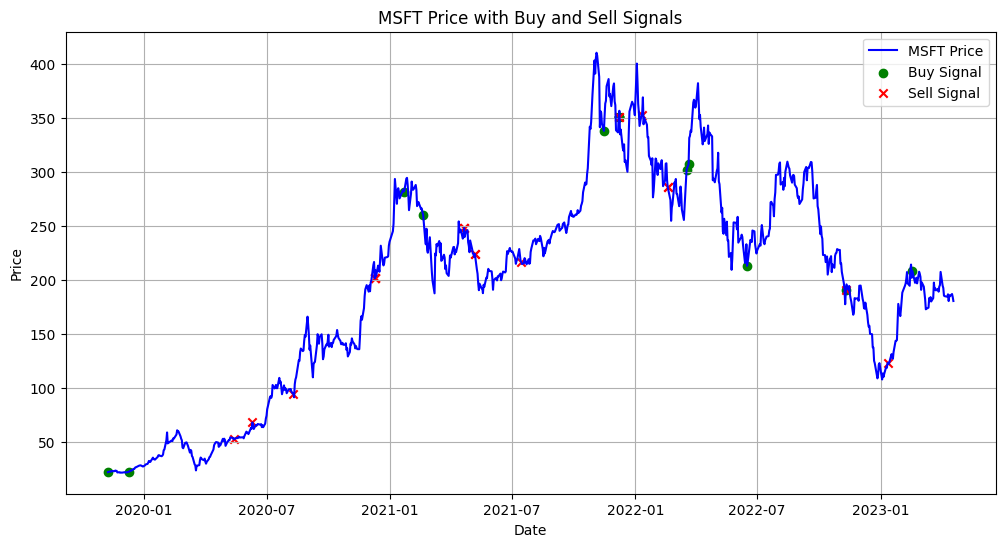

In [ ]:
stock = 'TSLA'

msft_trades = performance_df[performance_df['ticker'] == stock].copy()

msft_price = yf.download(stock, start=msft_trades['signal_date'].min(), end=msft_trades['signal_date'].max())
msft_price = msft_price['Close']

# Ensure msft_trades signal_date is datetime and set as index for easier lookup
msft_trades['signal_date'] = pd.to_datetime(msft_trades['signal_date'])
msft_trades.set_index('signal_date', inplace=True)

# Align signals with msft_price index and filter out dates where no price data exists
aligned_signals = msft_trades.loc[msft_price.index.intersection(msft_trades.index)]

import matplotlib.pyplot as plt

# plot buy and sell signals
plt.figure(figsize=(12, 6))
plt.plot(msft_price.index, msft_price.values, label='MSFT Price', color='blue')

# Plot buy signals
buy_signals = aligned_signals[aligned_signals['signal'] == 1]
plt.scatter(buy_signals.index, msft_price.loc[buy_signals.index], marker='o', color='green', label='Buy Signal')

# Plot sell signals
sell_signals = aligned_signals[aligned_signals['signal'] == -1]
plt.scatter(sell_signals.index, msft_price.loc[sell_signals.index], marker='x', color='red', label='Sell Signal')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT Price with Buy and Sell Signals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
msft_return = (msft_price.iloc[-1] - msft_price.iloc[0]) / msft_price.iloc[0]
print(f"MSFT Return: {msft_return.iloc[0] * 100:.2f}%")
print(f"MSFT gain: {(msft_price.iloc[-1] - msft_price.iloc[0]).iloc[0]:.2f}")

buy_sell_combined = pd.concat([buy_signals, sell_signals]).sort_index()

# buy_sell_combined = buy_sell_combined[buy_sell_combined['congress'] == "Josh Gottheimer"]

position = 0
account = 0.0 # Initialize account as float to handle potential decimal values

for signal_date, row in buy_sell_combined.iterrows():
    signal = row['signal']
    try:
        # Find the closest date in msft_price index at or after the signal_date
        closest_price_date = msft_price.index.asof(signal_date)

        if closest_price_date is None:
             print(f"Warning: No price data found on or after {signal_date}. Skipping trade.")
             continue

        current_price = msft_price.loc[closest_price_date]

        # Extract the scalar value from the Series if needed
        if isinstance(current_price, pd.Series):
            current_price = current_price.iloc[0]

        if signal == 1 and position == 0: # Only buy if not already in a position
            position = 1
            account -= current_price # Subtract price for a buy
            # print(f"Bought at {signal_date.date()}: ${current_price:.2f}")
        elif signal == -1 and position == 1: # Only sell if in a long position
            position = 0
            account += current_price # Add price for a sell
            # print(f"Sold at {signal_date.date()}: ${current_price:.2f}")


    except Exception as e:
        print(f"An error occurred processing signal date {signal_date}: {e}")
        pass # Skip this trade if any other error occurs


# After the loop, if still holding shares, liquidate at the last price
if position == 1:
    last_price = msft_price.iloc[-1].iloc[0]
    account += last_price
    # print(f"Liquidated remaining position at {msft_price.index[-1].date()}: ${last_price:.2f}")


print(f"Final Account Value: ${account:.2f}, position: {position}")

MSFT Return: 703.48%
MSFT gain: 158.11
Final Account Value: $-129.38, position: 1


In [ ]:
import pandas as pd
import numpy as np

congress_members = ['Nancy Pelosi', 'Josh Gottheimer', 'Michael T. McCaul', 'Ro Khanna']
i=0
congress_members = congress_members[i:i+1]

# 1. Filter only purchase trades
trades = pd.read_csv("trades.csv")
trades['file_date'] = pd.to_datetime(trades['file_date'], format='%m/%d/%Y')
trades['trade_date'] = pd.to_datetime(trades['trade_date'], format='%m/%d/%Y')
trades = trades[trades['transaction'] == "Purchase"]
trades = trades[trades['congress'].isin(congress_members)]

# Delist tickers
# 2. Align file_date to month-end (to match price data)
trades['month'] = trades['file_date'].dt.to_period('M').dt.to_timestamp('M')

# 3. Create signal: which tickers were purchased in each month
monthly_signals = trades.groupby('month')['ticker'].apply(list)

monthly_signals

,ticker
month,
2015-01-31,[DIS]
2015-07-31,"[HTZ, HTZ]"
2016-02-29,"[AAPL, DIS]"
2016-05-31,"[SQ, AAPL]"
2017-02-28,"[SQ, AAPL]"
2017-07-31,[AAPL]
2018-02-28,"[AAPL, AAPL]"
2018-04-30,[DBX]
2018-09-30,"[FB, AMZN]"


In [ ]:
import yfinance as yf

# 1. Pull monthly prices
tickers = trades['ticker'].str.upper().unique().tolist()

successful_tickers = []
failed_tickers = []

price_data = pd.DataFrame()

for idx, ticker in enumerate(tickers):
    print("Processing ticker: " + ticker + " (" + str(idx + 1) + "/" + str(len(tickers)) + ")")

    try:
        data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
        if not data.empty:
            successful_tickers.append(ticker)
            price_data[ticker] = data
        else:
            failed_tickers.append(ticker)
    except Exception as e:
        failed_tickers.append(ticker)

trades = trades[~trades['ticker'].isin(failed_tickers)]
monthly_prices = price_data.resample('M').last()
monthly_returns = monthly_prices.pct_change()

Processing ticker: ABBV (1/452)
Processing ticker: APP (2/452)
Processing ticker: ASML (3/452)
Processing ticker: CRM (4/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GLW (5/452)
Processing ticker: LLY (6/452)
Processing ticker: MSFT (7/452)
Processing ticker: SE (8/452)
Processing ticker: TEL (9/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-0

Processing ticker: TSLA (10/452)
Processing ticker: UBER (11/452)
Processing ticker: BABA (12/452)
Processing ticker: DHI (13/452)
Processing ticker: FI (14/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-0

Processing ticker: HD (15/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LNG (16/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MMM (17/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: RTX (18/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SCHW (19/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TLK (20/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TPH (21/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TTNDY (22/452)
Processing ticker: BKNG (23/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DASH (24/452)
Processing ticker: GILD (25/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: IBM (26/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ICE (27/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: META (28/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: V (29/452)
Processing ticker: WMT (30/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ABT (31/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AVGO (32/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DSCSY (33/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SHOP (34/452)
Processing ticker: SNOW (35/452)
Processing ticker: TWLO (36/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UNP (37/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: XYZ (38/452)
Processing ticker: ABEV (39/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BRK.B (40/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: CDRE (41/452)
Processing ticker: CLPBY (42/452)
Processing ticker: D (43/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GBOOY (44/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GMAB (45/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: JNJ (46/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: KO (47/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MA (48/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NSRGY (49/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PAR (50/452)
Processing ticker: SHEL (51/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UNICY (52/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AMD (53/452)
Processing ticker: AMZN (54/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CAT (55/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GOOG (56/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HSY (57/452)
Processing ticker: IBIT (58/452)
Processing ticker: INTC (59/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: JPM (60/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NVDA (61/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PANW (62/452)
Processing ticker: SCCO (63/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UPS (64/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GOOGL (65/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TEM (66/452)
Processing ticker: VST (67/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AAPL (68/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GS (69/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SQ']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: SQ (70/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: THR (71/452)
Processing ticker: ADBE (72/452)
Processing ticker: AMAT (73/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DUK (74/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NOW (75/452)
Processing ticker: NSC (76/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: KKR (77/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MELI (78/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NTRA (79/452)
Processing ticker: COST (80/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GSK (81/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LRCX (82/452)
Processing ticker: NEE (83/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: OXY (84/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: QCOM (85/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BX (86/452)
Processing ticker: DELL (87/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: FDX (88/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SO (89/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TSCO (90/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ALGM (91/452)
Processing ticker: CHRD (92/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: EPAC (93/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GTES (94/452)
Processing ticker: MFC (95/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PPBI (96/452)
Processing ticker: PYPL (97/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TCBI (98/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: USPH (99/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VRT (100/452)
Processing ticker: XNGSY (101/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DLR (102/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CRNX (103/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HDB (104/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: IRT (105/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MCD (106/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SSMXY (107/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TMO (108/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CAH (109/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: CRWD (110/452)
Processing ticker: FWRG (111/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SBUX (112/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SPOT (113/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TNDM (114/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LULU (115/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: KMI (116/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ATRC (117/452)
Processing ticker: FCX (118/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: FLYW (119/452)
Processing ticker: FNA (120/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FNA']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ISRG (121/452)
Processing ticker: LZB (122/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NOC (123/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: RHHBY (124/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: SGIOY (125/452)
Processing ticker: SHLS (126/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SNDR (127/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SWTX (128/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VIAV (129/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AEIS (130/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: STRL (131/452)
Processing ticker: BWIN (132/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: HLN (133/452)
Processing ticker: INTA (134/452)
Processing ticker: LOPE (135/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NTDOY (136/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UMBF (137/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ADC (138/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BNTX (139/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: DAVA (140/452)
Processing ticker: FICO (141/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: FOXF (142/452)
Processing ticker: HLMN (143/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: OCFC (144/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: TCEHY (145/452)
Processing ticker: ZTO (146/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DASTY (147/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: PWP (148/452)
Processing ticker: DBSDY (149/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LRLCY (150/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ABG (151/452)
Processing ticker: AGIO (152/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ALNY (153/452)
Processing ticker: APD (154/452)
Processing ticker: BAP (155/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: GTLS (156/452)
Processing ticker: HELE (157/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: HSHCY (158/452)
Processing ticker: ON (159/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PNGAY (160/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PTEN (161/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PYCR (162/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PYCR']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SSDOY (163/452)
Processing ticker: TSM (164/452)
Processing ticker: CELH (165/452)
Processing ticker: COCO (166/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: EW (167/452)
Processing ticker: SONY (168/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ANET (169/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PWR (170/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ADYEY (171/452)
Processing ticker: ALGT (172/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BCRX (173/452)
Processing ticker: CCI (174/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: DCO (175/452)
Processing ticker: EXAS (176/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: FANUY (177/452)
Processing ticker: FIS (178/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: FSLR (179/452)
Processing ticker: GWW (180/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: IART (181/452)
Processing ticker: JBL (182/452)
Processing ticker: NCLTY (183/452)
Processing ticker: NVZMY (184/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: PHR (185/452)
Processing ticker: RVLV (186/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SHYF (187/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SLGN (188/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data


Processing ticker: SMNNY (189/452)
Processing ticker: TWKS (190/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWKS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UTZ (191/452)
Processing ticker: VCYT (192/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VZ (193/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ASAZY (194/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: CHGCY (195/452)
Processing ticker: ETN (196/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: NFLX (197/452)
Processing ticker: REGN (198/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AORT (199/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AZTA (200/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: CSPCY (201/452)
Processing ticker: HMN (202/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SAP (203/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: SRPT (204/452)
Processing ticker: TXN (205/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: MNST (206/452)
Processing ticker: TDG (207/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AMGN (208/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: APPF (209/452)
Processing ticker: ARQT (210/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: CHX (211/452)
Processing ticker: VBTX (212/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ALGN (213/452)
Processing ticker: MRNA (214/452)
Processing ticker: MS (215/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: AAGIY (216/452)
Processing ticker: CBZ (217/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: INTU (218/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: MDB (219/452)
Processing ticker: TTD (220/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: WDAY (221/452)
Processing ticker: ADP (222/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: COF (223/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: COP (224/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DE (225/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ETSY (226/452)
Processing ticker: HUBS (227/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MTCH (228/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ORCL (229/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ROK (230/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SNAP (231/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: INSM (232/452)
Processing ticker: MAR (233/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UNH (234/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ALIZY (235/452)
Processing ticker: ABNB (236/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BHP (237/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CTSH (238/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SGEN (239/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SGEN']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: STAG (240/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: EFX (241/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SIVB (242/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SIVB']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: TGT (243/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TT (244/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: XP (245/452)
Processing ticker: DFKCY (246/452)
Processing ticker: ITT (247/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PPRUY (248/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PG (249/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: QQQ (250/452)
Processing ticker: FMX (251/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data


Processing ticker: IFNNY (252/452)
Processing ticker: CCXI (253/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CCXI']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True


Processing ticker: CRNC (254/452)
Processing ticker: CVET (255/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CVET']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SPXC (256/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TEX (257/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LOW (258/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MCK (259/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ENPH (260/452)
Processing ticker: ICUI (261/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VRSK (262/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AFL (263/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CLX (264/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CVX (265/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LMT (266/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: WBA (267/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DIS (268/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AB (269/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AXP (270/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BIIB (271/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: HQY (272/452)
Processing ticker: OLLI (273/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MDT (274/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ITCI (275/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ITCI']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: MTX (276/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MU (277/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: RBLX (278/452)
Processing ticker: PENN (279/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LHCG (280/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LHCG']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: AZO (281/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: SLVM (282/452)
Processing ticker: AFRM (283/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: EBS (284/452)
Processing ticker: DWAC (285/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DWAC']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HALO (286/452)
Processing ticker: ALB (287/452)
Processing ticker: SFTBY (288/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TPR (289/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MTDR (290/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PGR (291/452)
Processing ticker: IP (292/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: T (293/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: STX (294/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VMC (295/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: FB (296/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1735707600")')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BDX (297/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TFC (298/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: LPRO (299/452)
Processing ticker: CVNA (300/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISCA']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: DISCA (301/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: EL (302/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HCA (303/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: MGY (304/452)
Processing ticker: ROKU (305/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SSNC (306/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TWTR (307/452)
Processing ticker: W (308/452)
Processing ticker: ESTC (309/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ALLY (310/452)
Processing ticker: CREE (311/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CREE']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DRI (312/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LUKOY']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LUKOY (313/452)
Processing ticker: PFGC (314/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: SAM (315/452)
Processing ticker: SYF (316/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: Z (317/452)
Processing ticker: PAGS (318/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BAC (319/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CRSP (320/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: DKNG (321/452)
Processing ticker: SJM (322/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BRKS (323/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRKS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MO (324/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: CSTL (325/452)
Processing ticker: MEDP (326/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: APH (327/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: PINS (328/452)
Processing ticker: VTRS (329/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PRIM (330/452)
Processing ticker: ABCB (331/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ALC (332/452)
Processing ticker: BBVA (333/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BEN (334/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: BMRN (335/452)
Processing ticker: BOOT (336/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CATY (337/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CRY (338/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CRY']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: EBSB (339/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EBSB']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: FLT (340/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FLT']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HAE (341/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LYFT (342/452)
Processing ticker: PSX (343/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: ROG (344/452)
Processing ticker: SBCF (345/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: WBS (346/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DEO (347/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: IGGHY (348/452)
Processing ticker: CCMP (349/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CCMP']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CHL (350/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CHL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RDS.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')


Processing ticker: RDS.B (351/452)
Processing ticker: ITUB (352/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GRUB (353/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GRUB']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PM (354/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SUPN (355/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: KMTUY (356/452)
Processing ticker: RIO (357/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjus

Processing ticker: SBGSY (358/452)
Processing ticker: CACI (359/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DSGX (360/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: QDEL (361/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UL (362/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UAL (363/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WORK']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: WORK (364/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: RPD (365/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ABMD (366/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABMD']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BIDU (367/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CCL (368/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CENT (369/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CENTA (370/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CMP (371/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CYRX (372/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DNTUY (373/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DRQ']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: DRQ (374/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SLB (375/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SSL (376/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: UBSI (377/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: RHP (378/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HSBC (379/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LVS (380/452)
Processing ticker: HLI (381/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: WPX (382/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WPX']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: AMADY (383/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GMED (384/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZEN']: YFTzMissingError('possibly delisted; no timezone found')


Processing ticker: ZEN (385/452)


/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DAL (386/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GLOB (387/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HON (388/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MKTX (389/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NOVT (390/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SGSOY (391/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SITE (392/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SNPS (393/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ADDYY (394/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PODD (395/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: APNHY (396/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BAYRY (397/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DPLO (398/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DPLO']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ENTG (399/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: IBP (400/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: JGCCY (401/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: MTSI (402/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PATK (403/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['POL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: POL (404/452)
Processing ticker: PRAA (405/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TUP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TUP (406/452)
Processing ticker: VRTU (407/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VRTU']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PCAR (408/452)
Processing ticker: ATLKY (409/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CHDN (410/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: FAST (411/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LIN (412/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ILMN (413/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VEEV (414/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: YNDX (415/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['YNDX']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SKY (416/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PCLN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PCLN (417/452)
Processing ticker: AIR (418/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CGNX (419/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CSGP (420/452)
Processing ticker: DIFTY (421/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: FET (422/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GE (423/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: GIS (424/452)
Processing ticker: HIBB (425/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HIBB']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LZAGY (426/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: NKTR (427/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: PCTY (428/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: RHT (429/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RHT']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SPGI (430/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TEAM (431/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TMSNY (432/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SHPG (433/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SHPG']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: AIQUY (434/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: BA (435/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CBM (436/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CBM']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: CHKP (437/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DXCM (438/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: HRB (439/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: ICFI (440/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: IPXL (441/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: JBT (442/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JBT']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: LUV (443/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: QTS (444/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['QTS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: SLAB (445/452)
Processing ticker: SNHY (446/452)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SNHY']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: TKGBY (447/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: URI (448/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: VRTX (449/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: WB (450/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']


Processing ticker: DBX (451/452)


/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)['Close']
/tmp/ipython-input-13-3565828858.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[ticker] = data
/tmp/ipython-input-13-3565828858.py:25: FutureWarning: 'M' is deprecated and will be removed in a fu

Processing ticker: HTZ (452/452)


/tmp/ipython-input-13-3565828858.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = monthly_prices.pct_change()


In [ ]:
from collections import Counter

# 2. Initialize portfolio tracking
portfolio_value = []
dates = monthly_prices.index
holdings = {}  # {ticker: weight}
holdings_time = {}

holding_period = 2

initial_value = 1_000_000
current_value = initial_value

for date in dates:
    date_str = str(date.date())

    # Get return for current holdings
    if holdings:
        weights = np.array(list(holdings.values()))
        tickers_held = list(holdings.keys())
        returns = monthly_returns.loc[date, tickers_held].fillna(0).values
        portfolio_return = np.dot(weights, returns)
        current_value *= (1 + portfolio_return)
    else:
        portfolio_return = 0.0

    portfolio_value.append({'date': date, 'value': current_value, 'return': portfolio_return})

    # Update holdings if any new trades filed this month
    if date in monthly_signals.index:
        new_tickers = set([t for t in monthly_signals.loc[date] if t in monthly_prices.columns])
        if new_tickers:
            for ticker in holdings_time.keys():
                holdings_time[ticker] = max(0, holdings_time[ticker] - 1)

            holdings_time.update({ticker: holding_period for ticker in new_tickers})

            total_weight = sum(holdings_time.values())
            holdings = {ticker: weight / total_weight for ticker, weight in holdings_time.items()}

portfolio_df = pd.DataFrame(portfolio_value).set_index('date')
portfolio_df

,value,return
date,,
2015-01-31,1.000000e+06,0.000000
2015-02-28,1.144239e+06,0.144239
2015-03-31,1.153144e+06,0.007782
2015-04-30,1.195251e+06,0.036514
2015-05-31,1.213390e+06,0.015177
...,...,...
2024-08-31,8.925528e+06,0.029635
2024-09-30,9.099817e+06,0.019527
2024-10-31,9.279372e+06,0.019732


[*********************100%***********************]  1 of 1 completed


Alpha: 1.0946% per month, or 13.9557% annually
Beta: 1.0483
Sharpe Ratio: 0.2909


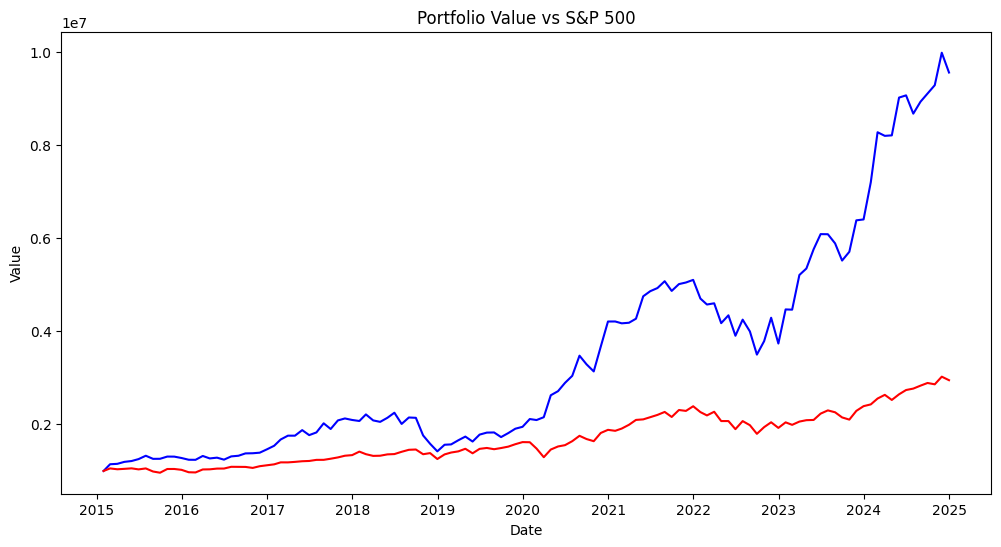

,value,return,total_return,sp500_value,sp500_return,sp500_total_return,excess_return
date,,,,,,,
2015-01-31,1.000000e+06,0.000000,0.000000,1.000000e+06,0.000000,0.000000,0.000000
2015-02-28,1.144239e+06,0.144239,0.144239,1.054893e+06,0.054893,0.054893,0.089347
2015-03-31,1.153144e+06,0.007782,0.153144,1.036541e+06,-0.017396,0.036541,0.116603
2015-04-30,1.195251e+06,0.036514,0.195251,1.045374e+06,0.008521,0.045374,0.149877
2015-05-31,1.213390e+06,0.015177,0.213390,1.056341e+06,0.010491,0.056341,0.157049
...,...,...,...,...,...,...,...
2024-08-31,8.925528e+06,0.029635,7.925528,2.831292e+06,0.022835,1.831292,6.094236
2024-09-30,9.099817e+06,0.019527,8.099817,2.888476e+06,0.020197,1.888476,6.211342
2024-10-31,9.279372e+06,0.019732,8.279372,2.859889e+06,-0.009897,1.859889,6.419483


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime

# S&P 500 Monthly Returns
sp500 = yf.download('^GSPC', start="2015-01-01", end="2025-01-01")['Close']
sp500_monthly_returns = sp500.resample('ME').last().pct_change().fillna(0)['^GSPC'].tolist() # Fill NaN with 0
sp500_value = [initial_value]
for i in range(1, len(sp500_monthly_returns)):
    sp500_value.append(sp500_value[i-1] * (1 + sp500_monthly_returns[i]))

portfolio_df['total_return'] = portfolio_df['value'] / initial_value - 1

portfolio_df['sp500_value'] = sp500_value
portfolio_df['sp500_return'] = sp500_monthly_returns
portfolio_df['sp500_total_return'] = portfolio_df['sp500_value'] / initial_value - 1

# Risk Free Rate
rf_data = web.DataReader('DGS1MO', 'fred', datetime(2015, 1, 1), datetime(2024, 12, 31))
rf_monthly = (1 + rf_data['DGS1MO'].ffill() / 100)**(1/12) - 1
rf_monthly = rf_monthly.resample('ME').ffill()
rf_monthly = rf_monthly.iloc[1:]

# Alpha
merged = portfolio_df[['return', 'sp500_return']].iloc[1:]
merged['excess_market'] = merged['sp500_return'] - rf_monthly.values
merged['excess_portfolio'] = merged['return'] - rf_monthly.values

# Reshape for regression
X = sm.add_constant(merged['excess_market'])
y = merged['excess_portfolio']

# Fit CAPM: r_p = alpha + beta * r_m + error
model = sm.OLS(y, X).fit()
alpha = model.params['const']
beta = model.params['excess_market']

print(f"Alpha: {alpha:.4%} per month, or {(1 + alpha)**12 - 1:.4%} annually")
print(f"Beta: {beta:.4f}")

# Sharpe Ratio
excess_return = portfolio_df['return'].iloc[1:] - rf_monthly.values
sharpe_ratio = np.mean(excess_return) / np.std(excess_return)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

portfolio_df['excess_return'] = portfolio_df['total_return'] - portfolio_df['sp500_total_return']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['value'], label='Portfolio Value', color='blue')
plt.plot(portfolio_df.index, portfolio_df['sp500_value'], label='S&P 500 Value', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Value vs S&P 500')
plt.show()

portfolio_df.to_csv('portfolio_value.csv')
portfolio_df

In [ ]:
monthly_signals = trades.groupby('month')['ticker'].apply(list)

# Step 1: Add sale trades to the dataset
sales = pd.read_csv("trades.csv")
sales['file_date'] = pd.to_datetime(sales['file_date'], format='%m/%d/%Y')
sales['trade_date'] = pd.to_datetime(sales['trade_date'], format='%m/%d/%Y')
sales = sales[sales['transaction'] == "Sale"]
sales = sales[sales['congress'].isin(congress_members)]

sales['month'] = sales['file_date'].dt.to_period('M').dt.to_timestamp('M')
monthly_sales = sales.groupby('month')['ticker'].apply(list)

# Step 2: Modified backtest loop with sale-based exit logic
portfolio_value = []
holdings = {}  # persistent across months
current_value = 1_000_000

for date in dates:
    # 1. Compute monthly return
    if holdings:
        weights = np.array(list(holdings.values()))
        tickers_held = list(holdings.keys())
        returns = monthly_returns.loc[date, tickers_held].fillna(0).values
        portfolio_return = np.dot(weights, returns)
        current_value *= (1 + portfolio_return)
    else:
        portfolio_return = 0.0

    portfolio_value.append({'date': date, 'value': current_value, 'return': portfolio_return})

    # 2. Add new purchases (accumulate them)
    if date in monthly_signals.index:
        new_tickers = set([t for t in monthly_signals.loc[date] if t in monthly_prices.columns])
        for ticker in new_tickers:
            if ticker not in holdings:
                holdings[ticker] = 0  # temporary placeholder
        # Recalculate weights (equal-weight across all positions)
        equal_weight = 1 / len(holdings)
        holdings = {k: equal_weight for k in holdings}

    # 3. Process sales (remove positions)
    if date in monthly_sales.index:
        tickers_to_sell = set(monthly_sales.loc[date])
        for t in tickers_to_sell:
            holdings.pop(t, None)  # remove if in portfolio
        # Recalculate weights
        if holdings:
            equal_weight = 1 / len(holdings)
            holdings = {k: equal_weight for k in holdings}

portfolio_df = pd.DataFrame(portfolio_value).set_index('date')

portfolio_df

,value,return
date,,
2015-01-31,1.000000e+06,0.000000
2015-02-28,1.144239e+06,0.144239
2015-03-31,1.153144e+06,0.007782
2015-04-30,1.195251e+06,0.036515
2015-05-31,1.213391e+06,0.015177
...,...,...
2024-08-31,3.081810e+06,0.011288
2024-09-30,3.165853e+06,0.027271
2024-10-31,3.151673e+06,-0.004479


/tmp/ipython-input-37-574914777.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start="2015-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  1 of 1 completed


Alpha: 0.1271% per month, or 1.5360% annually
Beta: 0.9544


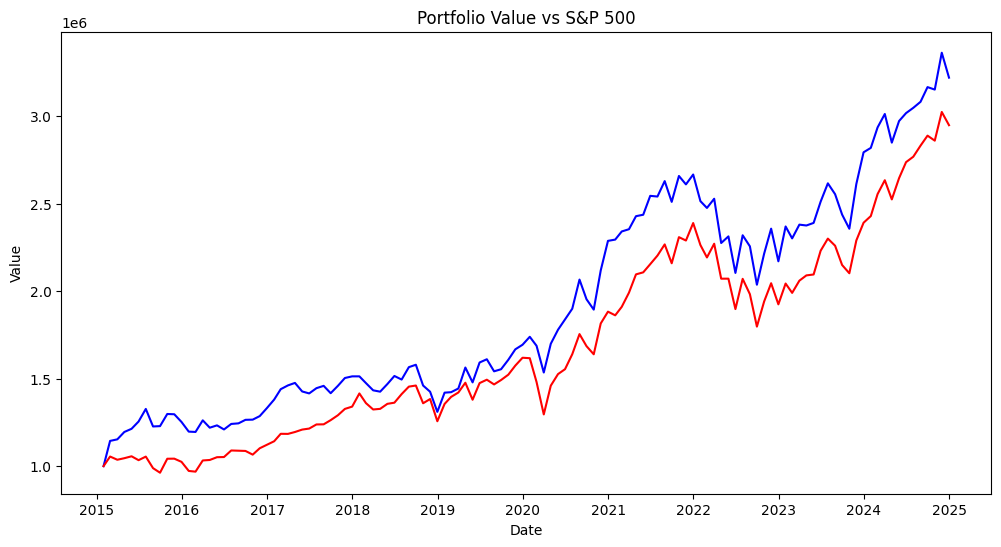

,value,return,total_return,sp500_value,sp500_return,sp500_total_return,excess_return
date,,,,,,,
2015-01-31,1.000000e+06,0.000000,0.000000,1.000000e+06,0.000000,0.000000,0.000000
2015-02-28,1.144239e+06,0.144239,0.144239,1.054893e+06,0.054893,0.054893,0.089347
2015-03-31,1.153144e+06,0.007782,0.153144,1.036541e+06,-0.017396,0.036541,0.116603
2015-04-30,1.195251e+06,0.036515,0.195251,1.045374e+06,0.008521,0.045374,0.149877
2015-05-31,1.213391e+06,0.015177,0.213391,1.056341e+06,0.010491,0.056341,0.157050
...,...,...,...,...,...,...,...
2024-08-31,3.081810e+06,0.011288,2.081810,2.831292e+06,0.022835,1.831292,0.250518
2024-09-30,3.165853e+06,0.027271,2.165853,2.888476e+06,0.020197,1.888476,0.277377
2024-10-31,3.151673e+06,-0.004479,2.151673,2.859889e+06,-0.009897,1.859889,0.291784


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime

# S&P 500 Monthly Returns
sp500 = yf.download('^GSPC', start="2015-01-01", end="2025-01-01")['Close']
sp500_monthly_returns = sp500.resample('ME').last().pct_change().fillna(0)['^GSPC'].tolist() # Fill NaN with 0
sp500_value = [initial_value]
for i in range(1, len(sp500_monthly_returns)):
    sp500_value.append(sp500_value[i-1] * (1 + sp500_monthly_returns[i]))

portfolio_df['total_return'] = portfolio_df['value'] / initial_value - 1

portfolio_df['sp500_value'] = sp500_value
portfolio_df['sp500_return'] = sp500_monthly_returns
portfolio_df['sp500_total_return'] = portfolio_df['sp500_value'] / initial_value - 1

# Risk Free Rate
rf_data = web.DataReader('DGS1MO', 'fred', datetime(2015, 1, 1), datetime(2024, 12, 31))
rf_monthly = (1 + rf_data['DGS1MO'].ffill() / 100)**(1/12) - 1
rf_monthly = rf_monthly.resample('ME').ffill()
rf_monthly = rf_monthly.iloc[1:]

# Alpha
merged = portfolio_df[['return', 'sp500_return']].iloc[1:]
merged['excess_market'] = merged['sp500_return'] - rf_monthly.values
merged['excess_portfolio'] = merged['return'] - rf_monthly.values

# Reshape for regression
X = sm.add_constant(merged['excess_market'])
y = merged['excess_portfolio']

# Fit CAPM: r_p = alpha + beta * r_m + error
model = sm.OLS(y, X).fit()
alpha = model.params['const']
beta = model.params['excess_market']

print(f"Alpha: {alpha:.4%} per month, or {(1 + alpha)**12 - 1:.4%} annually")
print(f"Beta: {beta:.4f}")

portfolio_df['excess_return'] = portfolio_df['total_return'] - portfolio_df['sp500_total_return']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['value'], label='Portfolio Value', color='blue')
plt.plot(portfolio_df.index, portfolio_df['sp500_value'], label='S&P 500 Value', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Value vs S&P 500')
plt.show()

portfolio_df

Use amount

In [ ]:
amount_map = {
    "Below $1,000": 5000,
    "$1,001 - $15,000": 8000,
    "$15,001 - $50,000": 32500,
    "$50,001 - $100,000": 75000,
    "$100,001 - $250,000": 175000,
    "$250,001 - $500,000": 375000,
    "$500,001 - $1,000,000": 750000,
    "$1,000,001 - $5,000,000": 3000000,
    "$5,000,001 - $25,000,000": 15000000,
    "$25,000,001 - $50,000,000": 37500000,
    "Over $50,000,000": 75000000
}

trades['amount_dollars'] = trades['amount_range'].map(amount_map)

asset_type_map = {'Stock': 1.0, 'Option': 2.0}
trades['asset_multiplier'] = trades['asset_type'].map(asset_type_map)

# Final conviction score
trades['conviction_score'] = trades['amount_dollars'] * trades['asset_multiplier']

# Align file date to month
trades['month'] = trades['file_date'].dt.to_period('M').dt.to_timestamp('M')

# Group by month and ticker, summing conviction
monthly_signals = trades.groupby(['month', 'ticker'])['conviction_score'].sum().unstack(fill_value=0)

# Filter dates
monthly_signals = monthly_signals.loc['2015-01-01':'2025-01-01']

# Preview (month × ticker) matrix
print(monthly_signals.tail())

trades

ticker           A   AA  AAGIY  AAL  AAON  AAP     AAPL  AAVL   AB     ABBV  \
month                                                                         
2024-08-31     0.0  0.0    0.0  0.0   0.0  0.0  40500.0   0.0  0.0      0.0   
2024-09-30     0.0  0.0    0.0  0.0   0.0  0.0  32000.0   0.0  0.0  24000.0   
2024-10-31     0.0  0.0    0.0  0.0   0.0  0.0   8000.0   0.0  0.0      0.0   
2024-11-30  8000.0  0.0    0.0  0.0   0.0  0.0  89000.0   0.0  0.0  16000.0   
2024-12-31     0.0  0.0    0.0  0.0   0.0  0.0  32500.0   0.0  0.0      0.0   

ticker      ...      ZBH  ZBRA  ZENV   ZG   ZI  ZION   ZM   ZS  ZTO  ZTS  
month       ...                                                           
2024-08-31  ...      0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
2024-09-30  ...      0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
2024-10-31  ...      0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
2024-11-30  ...   8000.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.

,congress,ticker,file_date,trade_date,transaction,amount_range,asset_type,month,amount_dollars,asset_multiplier,conviction_score
0,Josh Gottheimer,ABBV,2025-06-11,2025-05-22,Purchase,"$1,001 - $15,000",Stock,2025-06-30,8000,1.0,8000.0
1,Josh Gottheimer,APP,2025-06-11,2025-05-28,Purchase,"$1,001 - $15,000",Stock,2025-06-30,8000,1.0,8000.0
2,Josh Gottheimer,ASML,2025-06-11,2025-05-22,Purchase,"$1,001 - $15,000",Stock,2025-06-30,8000,1.0,8000.0
4,Josh Gottheimer,CRM,2025-06-11,2025-05-22,Purchase,"$1,001 - $15,000",Stock,2025-06-30,8000,1.0,8000.0
7,Josh Gottheimer,GLW,2025-06-11,2025-05-28,Purchase,"$1,001 - $15,000",Stock,2025-06-30,8000,1.0,8000.0
...,...,...,...,...,...,...,...,...,...,...,...
55729,Michael T. McCaul,NXPI,2015-01-21,2014-12-23,Purchase,"$50,001 - $100,000",Stock,2015-01-31,75000,1.0,75000.0
55730,Michael T. McCaul,NXPI,2015-01-21,2014-12-19,Purchase,"$50,001 - $100,000",Stock,2015-01-31,75000,1.0,75000.0
55731,Michael T. McCaul,NXPI,2015-01-21,2014-12-18,Purchase,"$50,001 - $100,000",Stock,2015-01-31,75000,1.0,75000.0
55733,Michael T. McCaul,WMB,2015-01-21,2014-12-19,Purchase,"$50,001 - $100,000",Stock,2015-01-31,75000,1.0,75000.0


In [ ]:
dates = monthly_prices.index

# Step 1: Add sale trades to the dataset
sales = pd.read_csv("trades.csv")
sales['file_date'] = pd.to_datetime(sales['file_date'], format='%m/%d/%Y')
sales['trade_date'] = pd.to_datetime(sales['trade_date'], format='%m/%d/%Y')
sales = sales[sales['transaction'] == "Sale"]
sales = sales[sales['congress'].isin(congress_members)]

sales['month'] = sales['file_date'].dt.to_period('M').dt.to_timestamp('M')
monthly_sales = sales.groupby('month')['ticker'].apply(list)

# Step 2: Modified backtest loop with sale-based exit logic
portfolio_value = []
holdings = {}  # persistent across months
current_value = 1_000_000

for date in dates:
    # 1. Compute monthly return
    if holdings:
        weights = np.array(list(holdings.values()))
        tickers_held = list(holdings.keys())
        returns = monthly_returns.loc[date, tickers_held].fillna(0).values
        portfolio_return = np.dot(weights, returns)
        current_value *= (1 + portfolio_return)
    else:
        portfolio_return = 0.0

    portfolio_value.append({'date': date, 'value': current_value, 'return': portfolio_return})

    # 2. Process sales and remove tickers if a politician files a sale
    if date in monthly_sales.index:
        tickers_to_sell = set(monthly_sales.loc[date])
        for t in tickers_to_sell:
            holdings.pop(t, None)  # remove if in portfolio

    # 3. Add new purchases and update weights using conviction scores
    if date in monthly_signals.index:
        signal_row = monthly_signals.loc[date]
        new_scores = signal_row[signal_row > 0]

        for ticker, score in new_scores.items():
            if ticker not in holdings:
                holdings[ticker] = 0  # temporary placeholder
            holdings[ticker] += score

        total_score = new_scores.sum()
        holdings = {k: v / total_score for k, v in holdings.items()}

portfolio_df = pd.DataFrame(portfolio_value).set_index('date')

portfolio_df

,value,return
date,,
2015-01-31,1.000000e+06,0.000000
2015-02-28,1.043456e+06,0.043456
2015-03-31,1.050912e+06,0.007146
2015-04-30,1.076924e+06,0.024751
2015-05-31,1.049910e+06,-0.025085
...,...,...
2024-08-31,2.630211e+06,0.011262
2024-09-30,2.718627e+06,0.033615
2024-10-31,2.658721e+06,-0.022035




---



In [ ]:
!pip install --upgrade yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

tickers = ["EXC", "FDX", "GOOG", "MELI", "MRK", "MS", "NVO", "PEP", "RHP", "SO", "UNH", "UPS"]
amount = ["15K-50K", "15K-50K", "1K-15K", "1K-15K", "1K-15K", "1K-15K", "1K-15K", "1K-15K", "15K-50K", "1K-15K", "1K-15K", "1K-15K"]

all_data = yf.download(tickers, start="2025-08-28", end="2025-08-29")[['High', 'Low']]
stacked_df = all_data.stack(level=1)
final_df = stacked_df.unstack(level=0)
final_df = final_df.swaplevel(axis=1).sort_index(axis=1)
final_df.index.name = 'Ticker'
final_df['Amount', ''] = amount # Add a second level to match the multi-index

estimated_number_of_shares_list = []
date_column = final_df.columns.get_level_values(0)[0]

for index, row in final_df.iterrows():
    # Access 'High' and 'Low' using the multi-level column index
    high = row[(date_column, 'High')]
    low = row[(date_column, 'Low')]
    amount_range = row[('Amount', '')] # Access the amount using the multi-level index

    if amount_range == "15K-50K":
        estimate = np.mean([int(15000 / low), int(50000 / high), int(15000 / high), int(50000 / low)])
        estimated_number_of_shares_list.append(int(estimate))
    elif amount_range == "1K-15K":
        estimate = np.mean([int(1000 / low), int(15000 / high), int(1000 / high), int(15000 / low)])
        estimated_number_of_shares_list.append(int(estimate))
    else:
         estimated_number_of_shares_list.append((0, 0)) # Handle other cases or add more conditions

final_df['Estimated Number of Shares', ''] = estimated_number_of_shares_list


display(final_df)

/tmp/ipython-input-1841283490.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(tickers, start="2025-08-28", end="2025-08-29")[['High', 'Low']]
[*********************100%***********************]  12 of 12 completed
/tmp/ipython-input-1841283490.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked_df = all_data.stack(level=1)


Date   2025-08-28 00:00:00                Amount Estimated Number of Shares
Price                 High          Low                                    
Ticker                                                                     
EXC              44.330002    43.669998  15K-50K                        738
FDX             232.990005   228.029999  15K-50K                        140
GOOG            212.899994   207.600006   1K-15K                         37
MELI           2504.370117  2396.969971   1K-15K                          2
MRK              84.250000    82.650002   1K-15K                         95
MS              150.389999   149.179993   1K-15K                         52
NVO              56.759998    55.709999   1K-15K                        141
PEP             148.039993   146.229996   1K-15K                         53
RHP              99.980003    97.699997  15K-50K                        328
SO               93.040001    92.070000   1K-15K                         85
UNH             304.470001   299.399994   1K-15K                         26
UPS              88.239998    86.459999   1K-15K                         91

In [ ]:
sector_list = []
industry_list = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info

    # Extract and print the sector and industry
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    sector_list.append(sector)
    industry_list.append(industry)
    print(f"Ticker: {ticker}, Sector: {sector}, Industry: {industry}")

final_df['Sector', ''] = sector_list
final_df['Industry', ''] = industry_list

display(final_df)

Ticker: EXC, Sector: Utilities, Industry: Utilities - Regulated Electric
Ticker: FDX, Sector: Industrials, Industry: Integrated Freight & Logistics
Ticker: GOOG, Sector: Communication Services, Industry: Internet Content & Information
Ticker: MELI, Sector: Consumer Cyclical, Industry: Internet Retail
Ticker: MRK, Sector: Healthcare, Industry: Drug Manufacturers - General
Ticker: MS, Sector: Financial Services, Industry: Capital Markets
Ticker: NVO, Sector: Healthcare, Industry: Drug Manufacturers - General
Ticker: PEP, Sector: Consumer Defensive, Industry: Beverages - Non-Alcoholic
Ticker: RHP, Sector: Real Estate, Industry: REIT - Hotel & Motel
Ticker: SO, Sector: Utilities, Industry: Utilities - Regulated Electric
Ticker: UNH, Sector: Healthcare, Industry: Healthcare Plans
Ticker: UPS, Sector: Industrials, Industry: Integrated Freight & Logistics


Date   2025-08-28 00:00:00                Amount Estimated Number of Shares  \
Price                 High          Low                                       
Ticker                                                                        
EXC              44.330002    43.669998  15K-50K                        738   
FDX             232.990005   228.029999  15K-50K                        140   
GOOG            212.899994   207.600006   1K-15K                         37   
MELI           2504.370117  2396.969971   1K-15K                          2   
MRK              84.250000    82.650002   1K-15K                         95   
MS              150.389999   149.179993   1K-15K                         52   
NVO              56.759998    55.709999   1K-15K                        141   
PEP             148.039993   146.229996   1K-15K                         53   
RHP              99.980003    97.699997  15K-50K                        328   
SO               93.040001    92.070000   1K-15K                         85   
UNH             304.470001   299.399994   1K-15K                         26   
UPS              88.239998    86.459999   1K-15K                         91   

Date                    Sector                        Industry  
Price                                                           
Ticker                                                          
EXC                  Utilities  Utilities - Regulated Electric  
FDX                Industrials  Integrated Freight & Logistics  
GOOG    Communication Services  Internet Content & Information  
MELI         Consumer Cyclical                 Internet Retail  
MRK                 Healthcare    Drug Manufacturers - General  
MS          Financial Services                 Capital Markets  
NVO                 Healthcare    Drug Manufacturers - General  
PEP         Consumer Defensive       Beverages - Non-Alcoholic  
RHP                Real Estate            REIT - Hotel & Motel  
SO                   Utilities  Utilities - Regulated Electric  
UNH                 Healthcare                Healthcare Plans  
UPS                Industrials  Integrated Freight & Logistics